In [1]:
from Sapphire.Utilities.Building import nanoico #Let's build a small example nanocluster
nanoico.Nanoalloy.create_alloy_ico(['Au', 'Au', 'Au', 'Au', 'Au'], 6, 4.07, 'Au561.xyz')
#Ico takes arguments: ( [ list of atoms as per the shells], number of shells, atomic distance (\AA))
#Atomic radius = 289pm -- 289 * sqrt(2) = 407pm Because FCC [Face centred cubic]

The file: Au561.xyz has been created


/home/robert/MyEnv/lib/python3.6/site-packages/Sapphire/Utilities/Building/nanoico.py:179: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  alloy_temp=np.array(alloy_temp)


Using the building tools in Sapphire, we are able to construct a small Au icosahedron of 561 atoms.
We may now proceed to perform some targetted alanysis on this object.

Text(0, 0.5, 'Probability density')

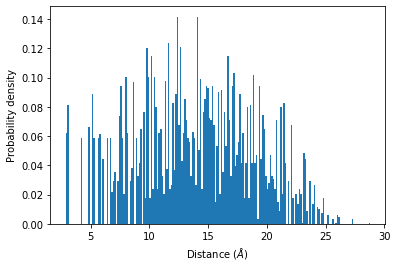

In [2]:
from Sapphire.Post_Process import Adjacent,Kernels,DistFuncs #Some basic tools for geometric analysis
from ase.io import read #Whilst this is a part of the core Sapphire setup, we can demonstrate its uitility more easily here

au = read('Au561.xyz')
pos = au.positions
dist = DistFuncs.Euc_Dist(pos) #Get a list of pairwise distances.
#Now why don't we visualise the pair distances as a distribution?
import matplotlib.pyplot as plt
a,b,c = plt.hist(dist, density=True, bins = 200)
plt.xlabel('Distance ($\AA$)')
plt.ylabel('Probability density')

This does not look particularly helpful, and so we shall make use of Sapphire's Kernel Density Estimators (KDEs) to get a smoother approximation on the pair distance distribution function.

We primarily advocate for the use of the Gaussian kernels, though others are supported.
A bandwidth of 0.05 should be adequate to acquire a good balance between smoothness and detail in the resultant distribution.

As a default, Sapphire only considers the first 6 Å of pair distances for the sake of speed when computing the full KDE. However, this is something which is easily varied, as explored in the PDDF tutorial.

In [3]:
#help(DistFuncs.Pair_Dist)
P = DistFuncs.RDF(System = None, Positions=pos)

Text(0, 0.5, 'G(R)')

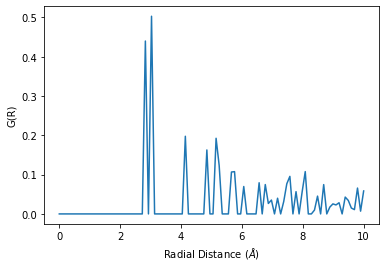

In [4]:
plt.plot(P.Radii,P.G)
plt.xlabel('Radial Distance ($\AA$)')
plt.ylabel('G(R)')

In [ ]:
help(DistFuncs.CoM_Dist)

In [5]:
K = Kernels.Gauss(dist, 0.05)

Cut-off is predicted to be 3.196 $\AA$


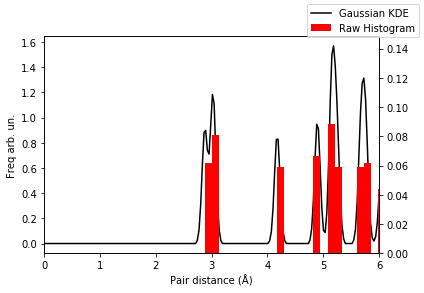

In [6]:
fig,ax = plt.subplots()
ax.plot(K.Space, K.Density, color = 'k', label = 'Gaussian KDE')
ax1 = ax.twinx()
a,b,c = ax1.hist(dist, density=True, bins = 200, color = 'r', label = 'Raw Histogram')
plt.xlim(0,6)
ax.set_xlabel('Pair distance (Å)')
ax.set_ylabel('Freq arb. un.')
fig.legend()
print("Cut-off is predicted to be %.3f $\AA$"%K.ReturnRCut())

As we can see, there is a distinct advantage in using the KDE method to compute the pair distance distribution function over the raw histogram. Namely, we are able to extract information more easily, and being an analytic function, taking derivatives to find minima is simple!


Next, we compute the adjacency matrix which is stored as a sparse scipy matrix to save on memory overheads. This simply requires the atomic positions, the pair distances we computed earlier, and the first minimum of the pair distance distribution function.

In [18]:
A = Adjacent.Adjacency_Matrix(Positions=pos, Distances=dist, R_Cut=K.R_Cut)
adj = A.ReturnAdj()
a = A.Adjacent


[]

We shall introduce the CNA function by running through the main workflow explicitly before hiding much of the machinary behind the curtain of python.

In [11]:
from Sapphire.CNA.FrameSignature import CNA
Sigs = {} #We shall not presupose the existence of any CNA signatures.
for i, atom in enumerate(au): #Iterate over all atoms in the cluster 
    cna = CNA(None, adj)
    cna.NN(i) #Aquire the nearest neighbours to the reference atom being considered
    for neigh in cna.neigh:
        sig = tuple((cna.R(i,neigh), cna.S(), cna.T()))
        try:
            Sigs[sig]+=1
        except KeyError:
            print(sig)
            Sigs[sig] = 1

'list' object has no attribute 'todense'


AttributeError: 'CNA' object has no attribute 'Adj'

As we can see, there are 5 CNA signatures associated with the Ih structure which have been identified. This is indeed as it should be. 

555 - indicative of a 5-fold symmetry axis.
422 & 421 - Indicative of FCC environment
322 & 321 are generally representative of surfaces with (111) Miller indices. This shall be expanded on later in the tutorial.

With our signatures collected, we may now evaluate their distribution.

In [ ]:
import numpy as np
xaxis = np.arange(0,len(Sigs)) #Define the range for the x axis
yaxis = np.array([x for x in Sigs.values()]) #Set the y axis values from the dictionary
xlabels = [ str(x) for x in Sigs.keys() ] #Create a list of labels for the bar chart

plt.bar(xaxis,yaxis)

plt.xticks(xaxis,xlabels, rotation = 45)
plt.xlabel('CNA signature')
plt.ylabel('Counts')

Now that we have a good feeling for what this distribution may feel like, we can begin to evaluate what the bonding environment itself may actually look like.

As such, we provide below two example functions to extract the positional information, given the cna signature, for the atoms and their evaluated bonds.

We may sort the bonds into 3 lists representing the following quantities:

    1. pair_edge = The bonding pair in question.
    2. s_edge = All of the bonds shared between the reference pair and their shared neighbours.
    3. t_edge = All of the bonds shared by the shared neighbours only.
    
We sort these three lissts manually so that we may have an easier time distinguishing environments.

We shall then extract five pairs, each of which have a unique cna signature, and plot graphically their bonding environments.

In [ ]:
def plotting_tool(cna=None, strut = None, reference = None, friend = None):
    node_xyz = np.zeros((2+len(cna.bonds), 3))
    node_xyz[0] = strut[int(reference)].position
    node_xyz[1] = strut[int(friend)].position
    for i,node in enumerate(cna.bonds):
        node_xyz[i+2] = strut[int(node)].position
        
    pair_edge = np.zeros((2,3))
    s_edge = np.zeros((2*len(cna.bonds),2,3))
    t_edge = np.zeros((len(cna.perm),2,3))
    
    pair_edge[0] = node_xyz[0]
    pair_edge[1] = node_xyz[1]
    
    for i, bond in enumerate(cna.bonds):
        s_edge[2*i][0] = au[int(reference)].position
        s_edge[2*i+1][0] = au[int(friend)].position
        s_edge[2*i][1] = au[int(bond)].position
        s_edge[2*i+1][1] = au[int(bond)].position
    
    for i, bond in enumerate(cna.perm):
        t_edge[i][0] = au[int(bond[0])].position
        t_edge[i][1] = au[int(bond[1])].position
    return node_xyz, pair_edge, s_edge, t_edge

def sig_plot(nodes, pair_edge, s_edges, t_edges, angle_A = 30, angle_B = 210):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    # Plot the nodes - alpha is scaled by "depth" automatically
    options = {"edgecolors": "tab:gray", "node_size": 200, "alpha": 0.9}
    for i in [0,1]:
        ax.scatter(*nodes[i].T, s=400, ec="w", color = 'r')

    for i, node in enumerate(nodes):
        if i >1:
            ax.scatter(*nodes[i].T, s=400, ec="w", color = 'k')

    ax.plot(*pair_edge.T, color="r", linewidth = 10)
    for vizedge in s_edges:
        ax.plot(*vizedge.T, color="k")
    for vizedge in t_edges:
        ax.plot(*vizedge.T, color="g")

    def _format_axes(ax):
        """Visualization options for the 3D axes."""
        # Turn gridlines off
        ax.grid(False)
        # Suppress tick labels
        # Set axes labels
        ax.set_xlabel("x (Å)")
        ax.set_ylabel("y (Å)")
        ax.set_zlabel("z (Å)")
        ax.view_init(angle_A, angle_B)
    _format_axes(ax)
    #fig.tight_layout()
    plt.show()

In [ ]:
cna = CNA(Adj = adj)
cna_555 = cna
cna_555.NN(0)
print(cna_555.neigh)
cna_555.R(0,1)
cna_555.S()
cna_555.T()
a,b,c,d = plotting_tool(cna_555,au,0,1)
sig_plot(a,b,c,d)

In [ ]:
cna = CNA(Adj = adj)
cna_422= cna
cna_422.NN(10)
print(cna_422.neigh)
r = cna_422.R(10,26)
s = cna_422.S()
t = cna_422.T()
print(tuple((r,s,t)))
a,b,c,d = plotting_tool(cna_422,au,10,26)
sig_plot(a,b,c,d, 15, 180)

In [ ]:
cna = CNA(Adj = adj)
cna_421 = cna
cna_421.NN(41)
print(cna_421.neigh)
r = cna_421.R(41,51)
s = cna_421.S()
t = cna_421.T()
print(tuple((r,s,t)))
a,b,c,d = plotting_tool(cna_421,au,0,1)
sig_plot(a,b,c,d,45,0)

In [ ]:
cna = CNA(adj = adj)
cna_322 = cna
cna_322.NN(500)
print(cna_322.neigh)
r = cna_322.R(500,501)
s = cna_322.S()
t = cna_322.T()
print(tuple((r,s,t)))
a,b,c,d = plotting_tool(cna_322,au,0,1)
sig_plot(a,b,c,d,135,135)

In [ ]:
cna = CNA(adj = adj, Fingerprint = True)
cna_311 = cna
cna_311.NN(560)
print(cna_311.neigh)
r = cna_311.R(560,558)
s = cna_311.S()
t = cna_311.T()
print(tuple((r,s,t)))
a,b,c,d = plotting_tool(cna_311,au,560,558)
sig_plot(a,b,c,d, 60, 90)

In [ ]:
cna = CNA(Adj = adj, Fingerprint = True)

In [ ]:
cna.calculate()

In [ ]:
pattern_dict = list(set(cna.Fingerprint))
y_axis = np.zeros(len(pattern_dict), int)
x_axis = np.arange(0, len(pattern_dict))
xlabels = [ str(x) for x in pattern_dict ] #Create a list of labels for the bar chart
for pat in cna.Fingerprint:
    y_axis[pattern_dict.index(pat)] += 1
plt.barh(x_axis,y_axis)
len(xlabels)
plt.yticks(x_axis,xlabels, rotation = 0)
plt.xlabel('Counts')
plt.ylabel('Pattern')

In [ ]:
cna = CNA(adj = adj, Fingerprint = True)
cna.calculate()

In [ ]:
cna.Fingerprint

In [ ]:
fig = plt.figure()
gs = fig.add_gridspec(1,2, hspace=0, wspace = 0)
axs = gs.subplots(sharex=True, sharey=True)
ax1,ax2 = axs.flatten()
cna = CNA(adj = adj, Fingerprint = True)
cna.NN(560)
r = cna_311.R(560,558)
s = cna_311.S()
t = cna_311.T()
print(tuple((r,s,t)))
a,b,c,d = plotting_tool(cna_311,au,560,558)
ax1 = sig_plot(a,b,c,d, 60, 90)

In [ ]:
cna = CNA(adj = adj, Fingerprint = True)
cna.NN(560)
for nn in cna.neigh:
    print(nn)
    r = cna.R(560,nn)
    s = cna.S()
    t = cna.T()
    print(tuple((r,s,t)))
    #,b,c,d = plotting_tool(cna,au,560,558)
    #ig_plot(a,b,c,d, 60, 90)